# Setup:


In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch

dtype = torch.cuda.FloatTensor

# Fitting a Simple Linear Model

## Step 1: Synthesize some data

To demonstrate fitting a model with TensorFlow's eager execution, we'll fit a linear model to some synthesized data (which includes some noise).

In the code, we  use the variable names `w` and `b` to represent the single weight and bias we'll use to fit our model.

In [3]:
import numpy as np
from torch.autograd import Variable

# The constants we'll try to fit our variables to:
true_w = 3
true_b = 2

NUM_EXAMPLES = 1000000  # 1000

# Our inputs:
inputs = np.random.normal(size=(NUM_EXAMPLES, 1))

# Our labels, with noise:
noise = np.random.normal(size=(NUM_EXAMPLES, 1))
labels = inputs * true_w + true_b + noise

X = Variable(torch.from_numpy(inputs).float().cuda())
y_true = Variable(torch.from_numpy(labels).float().cuda(), requires_grad=False)

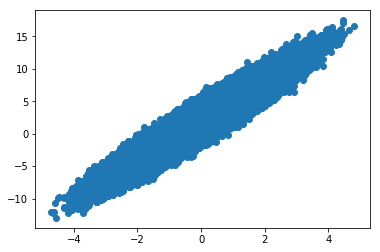

In [4]:
# Plot the Data (Optional)

import matplotlib.pyplot as plt

plt.scatter(inputs, labels)
plt.show()

## Step 2: Define our Model 

In [5]:
model = torch.nn.Sequential(
    torch.nn.Linear(1, 1),
).cuda()

## Step 3: Define our loss function

Our loss function is the standard L2 loss (where we reduce the loss to its mean across its inputs).

In [6]:
loss_fn = torch.nn.MSELoss()

In [7]:
# Test loss function (optional).

y_pred = model(X)
loss_fn(y_pred, y_true)

Variable containing:
 10.7368
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [8]:
# At this point, the variables exist, and can now be queried:

wb = model[0]
print("w: " + str(wb.weight))
print("b: " + str(wb.bias))

w: Parameter containing:
 0.8241
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

b: Parameter containing:
-0.2390
[torch.cuda.FloatTensor of size 1 (GPU 0)]



## Step 5: Create an optimizer

We'll use a `GradientDescentOptimizer` to fit our model.

In [9]:
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Step 6: Create a training loop

Of course, now we can simply turn all of this code into a self-standing training loop. We'll also capture our loss and approximations of `w` and `b` and plot them over time.

In [10]:
num_training_steps = 1000  # 10

loss_at_step = []
w_at_step = []
b_at_step = []

In [11]:
%%time

for step_num in range(num_training_steps):
    y_pred = model(X)
    loss = loss_fn(y_pred, y_true)
    loss_at_step.append(np.asscalar(loss.data.cpu().numpy()))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    wb = model[0]
    w_at_step.append(np.asscalar(wb.weight.data.cpu().numpy()))
    b_at_step.append(np.asscalar(wb.bias.data.cpu().numpy()))

CPU times: user 3.19 s, sys: 1.36 s, total: 4.55 s
Wall time: 4.57 s


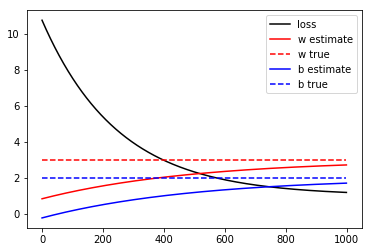

In [12]:
t = range(0, num_training_steps)
plt.plot(t, loss_at_step, 'k',
       t, w_at_step, 'r',
       t, [true_w] * num_training_steps, 'r--',
       t, b_at_step, 'b',
       t, [true_b] * num_training_steps, 'b--')
plt.legend(['loss', 'w estimate', 'w true', 'b estimate', 'b true'])
plt.show()